# Advanced Topics in Machine Learning - Assignment 0
## Task 1: Inner Workings of ResNet-152

This notebook explores the inner workings of ResNet-152 through transfer learning experiments, skip connection analysis, feature visualization, and training strategy comparisons on CIFAR-10.

## Setup and Data Loading
### Import Libraries and Setup Device

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision.models import ResNet152_Weights, resnet152

os.environ["TQDM_NOTEBOOK"] = "0"
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset Preparation
### Loading CIFAR-10 dataset with ImageNet normalization for ResNet compatibility.

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 1. Baseline Setup
### 1a-1b. Pre-trained ResNet-152 with Modified Classification Head
Setting up a pre-trained ResNet-152 and replacing the final layer for CIFAR-10 (10 classes).

In [3]:
# 1a. Use a pre-trained ResNet-152 from PyTorch
model_baseline = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the backbone
for param in model_baseline.parameters():
    param.requires_grad = False

# 1b. Replace the final classification layer
num_ftrs = model_baseline.fc.in_features
model_baseline.fc = nn.Linear(num_ftrs, 10) # 10 classes for CIFAR-10

model_baseline = model_baseline.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.fc.parameters(), lr=0.001)

### 1c-1d. Training and Evaluation Functions

In [4]:
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(trainloader, desc=f"Epoch {epoch+1} out of {num_epochs} [Training]")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(trainset)
        print(f"Epoch {epoch+1} out of {num_epochs}, Training Loss: {epoch_loss:.4f}")
        evaluate_model(model)
    return model

def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc="Evaluating")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'accuracy': f'{100 * correct / total:.2f}%'})
    
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f} %')
    return accuracy

### Training the Baseline Model
Training only the classification head while keeping backbone frozen.

In [5]:
# 1c & 1d. Train only the classification head and record performance
print("--- Starting Baseline Training ---")
model_baseline = train_model(model_baseline, criterion, optimizer, num_epochs=5)

--- Starting Baseline Training ---


Epoch 1 out of 5 [Training]: 100%|██████████| 782/782 [00:29<00:00, 26.17it/s, loss=0.75] 


Epoch 1 out of 5, Training Loss: 0.7499


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.47it/s, accuracy=79.34%]


Validation Accuracy: 79.34 %


Epoch 2 out of 5 [Training]: 100%|██████████| 782/782 [00:29<00:00, 26.65it/s, loss=0.35] 


Epoch 2 out of 5, Training Loss: 0.5951


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.78it/s, accuracy=80.36%]


Validation Accuracy: 80.36 %


Epoch 3 out of 5 [Training]: 100%|██████████| 782/782 [00:29<00:00, 26.72it/s, loss=0.411]


Epoch 3 out of 5, Training Loss: 0.5671


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.69it/s, accuracy=80.44%]


Validation Accuracy: 80.44 %


Epoch 4 out of 5 [Training]: 100%|██████████| 782/782 [00:30<00:00, 26.03it/s, loss=0.518]


Epoch 4 out of 5, Training Loss: 0.5527


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.20it/s, accuracy=80.68%]


Validation Accuracy: 80.68 %


Epoch 5 out of 5 [Training]: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s, loss=0.386]


Epoch 5 out of 5, Training Loss: 0.5358


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.39it/s, accuracy=82.01%]


Validation Accuracy: 82.01 %


## 2. Residual Connections in Practice
### 2a. Implementing Modified ResNet without Skip Connections
Creating a custom bottleneck block that disables skip connections.

In [6]:
def remove_skip_connection(block):
    """Remove skip connection from a ResNet bottleneck block"""
    
    def new_forward(x):
        out = block.conv1(x)
        out = block.bn1(out)
        out = block.relu(out)
        
        out = block.conv2(out)
        out = block.bn2(out)
        out = block.relu(out)
        
        out = block.conv3(out)
        out = block.bn3(out)
        out = block.relu(out) # skip connection removed here and go straight to output

        return out
    
    block.forward = new_forward
    return block

# fresh pre-trained model
model_no_skip = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)

# 2a. Disable skip connections in selected residual blocks
remove_skip_connection(model_no_skip.layer4[-1])
remove_skip_connection(model_no_skip.layer4[-2])

# freeze backbone and replace classifier head

for param in model_no_skip.parameters():
    param.requires_grad = False

num_ftrs = model_no_skip.fc.in_features
model_no_skip.fc = nn.Linear(num_ftrs, 10)
model_no_skip = model_no_skip.to(device)

optimizer_no_skip = optim.Adam(model_no_skip.fc.parameters(), lr=0.001)

### 2b. Training Modified Network and Comparison
Training the modified ResNet without skip connections and comparing with baseline.

In [7]:
# 2b. Re-train the modified network and compare with the baseline

print("--- Starting Training for Model with No Skip Connections ---")
model_no_skip = train_model(model_no_skip, criterion, optimizer_no_skip, num_epochs=5)

--- Starting Training for Model with No Skip Connections ---


Epoch 1 out of 5 [Training]: 100%|██████████| 782/782 [00:31<00:00, 25.14it/s, loss=0.647]


Epoch 1 out of 5, Training Loss: 1.0292


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.74it/s, accuracy=72.17%]


Validation Accuracy: 72.17 %


Epoch 2 out of 5 [Training]: 100%|██████████| 782/782 [00:31<00:00, 25.18it/s, loss=1.19] 


Epoch 2 out of 5, Training Loss: 0.8239


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s, accuracy=72.60%]


Validation Accuracy: 72.60 %


Epoch 3 out of 5 [Training]: 100%|██████████| 782/782 [00:29<00:00, 26.51it/s, loss=1.13] 


Epoch 3 out of 5, Training Loss: 0.7874


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 28.08it/s, accuracy=73.39%]


Validation Accuracy: 73.39 %


Epoch 4 out of 5 [Training]: 100%|██████████| 782/782 [00:28<00:00, 27.27it/s, loss=0.759]


Epoch 4 out of 5, Training Loss: 0.7681


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.83it/s, accuracy=73.99%]


Validation Accuracy: 73.99 %


Epoch 5 out of 5 [Training]: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s, loss=1.14] 


Epoch 5 out of 5, Training Loss: 0.7578


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.33it/s, accuracy=73.72%]

Validation Accuracy: 73.72 %


## 3. Feature Hierarchies and Representations
### 3a. Feature Extraction from Multiple Layers
Extracting features from early, middle, and late layers for visualization.

In [8]:
model_to_visualize = model_baseline.eval()

features = {}

def get_features(name):
    def hook(model, input, output):
        pooled_output = nn.functional.adaptive_avg_pool2d(output, 1).squeeze()
        features[name] = pooled_output.detach().cpu().numpy()
    return hook

# 3a. Register hooks at early, middle, and late layers
model_to_visualize.layer1.register_forward_hook(get_features('early_layer'))
model_to_visualize.layer3.register_forward_hook(get_features('middle_layer'))
model_to_visualize.layer4.register_forward_hook(get_features('late_layer'))

feature_list = {'early_layer': [], 'middle_layer': [], 'late_layer': []}
label_list = []


with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        if len(label_list) >= 1000:
            break
        images = images.to(device)
        _ = model_to_visualize(images)
        
        for layer_name in feature_list.keys():
            feature_list[layer_name].append(features[layer_name])
        
        label_list.append(labels.cpu().numpy())

concatenated_features = {}
for layer_name in feature_list.keys():
    concatenated_features[layer_name] = np.concatenate(feature_list[layer_name], axis=0)

labels_np = np.concatenate(label_list, axis=0)

labels_np = np.concatenate(label_list, axis=0)

### 3b. Feature Visualization using t-SNE
Visualizing how class separability evolves across network layers.

Running t-SNE for t-SNE of Early Layer Features (Layer 1)...


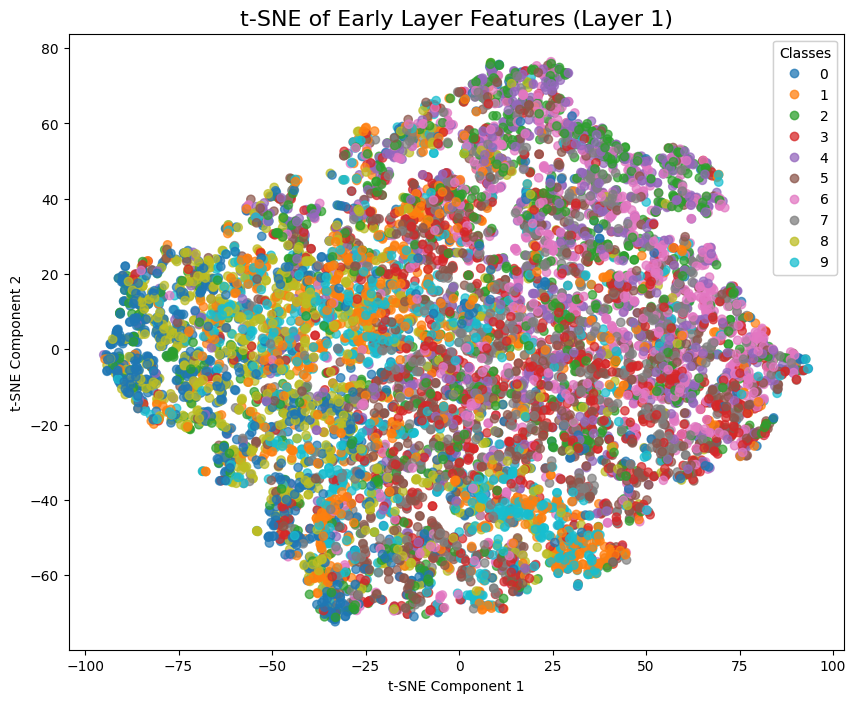

Running t-SNE for t-SNE of Middle Layer Features (Layer 3)...


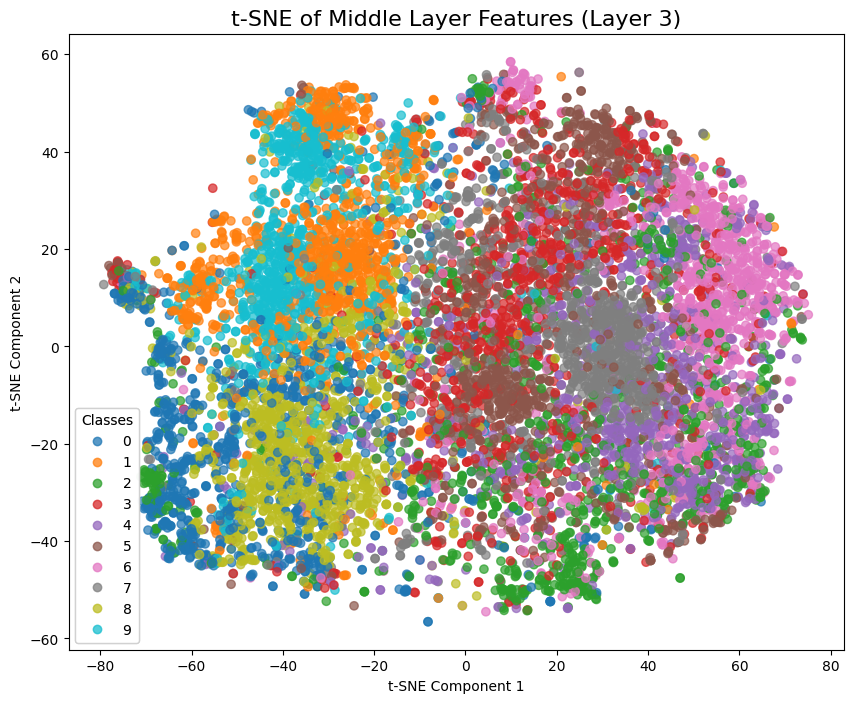

Running t-SNE for t-SNE of Late Layer Features (Layer 4)...


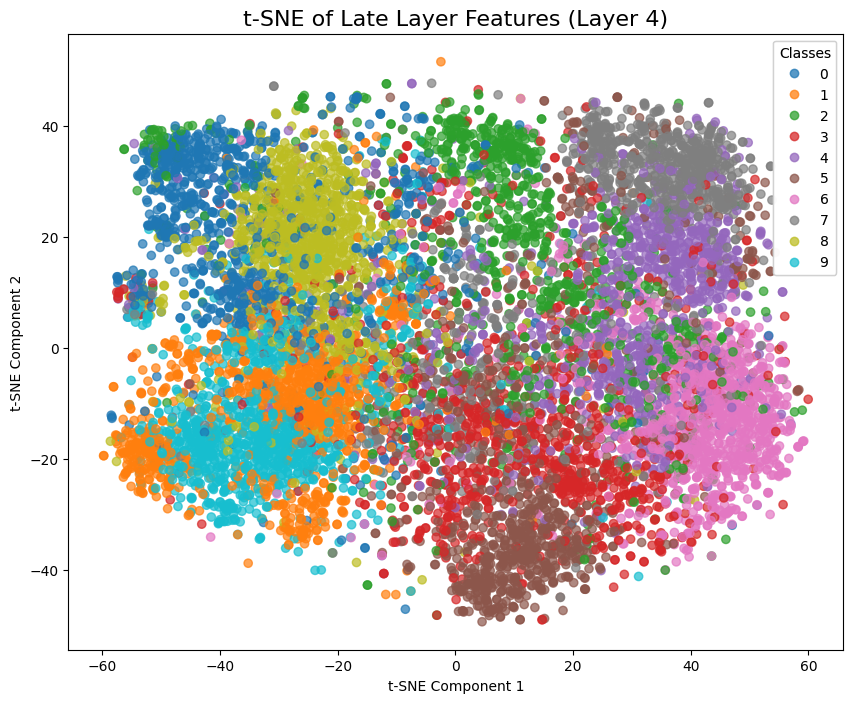

In [9]:
def plot_tsne(features, labels, title):
    print(f"Running t-SNE for {title}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.show()

# 3b. Visualize features using t-SNE
plot_tsne(concatenated_features['early_layer'], labels_np, 't-SNE of Early Layer Features (Layer 1)')
plot_tsne(concatenated_features['middle_layer'], labels_np, 't-SNE of Middle Layer Features (Layer 3)')
plot_tsne(concatenated_features['late_layer'], labels_np, 't-SNE of Late Layer Features (Layer 4)')

## 4. Transfer Learning and Generalization
### Comprehensive Comparison of Training Strategies
Comparing four different training approaches:
1. Full model with pre-trained weights
2. Full model from scratch
3. Final block only with pre-trained weights  
4. Final block only from scratch

In [10]:
def evaluate_model_v2(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc="Evaluating")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'accuracy': f'{100 * correct / total:.2f}%'})
    return 100 * correct / total

def train_model_with_history(model, criterion, optimizer, trainloader, testloader, device, num_epochs=5):
    val_accuracy_history = []
    initial_acc = evaluate_model_v2(model, testloader, device)
    val_accuracy_history.append(initial_acc)
    print(f"Initial Validation Accuracy: {initial_acc:.2f}%")

    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(trainloader, desc=f"Epoch {epoch+1} out of {num_epochs} [Training]")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item()})
        
        epoch_acc = evaluate_model_v2(model, testloader, device)
        val_accuracy_history.append(epoch_acc)
        print(f"Epoch {epoch+1} Validation Accuracy: {epoch_acc:.2f}%")
        
    return val_accuracy_history

In [11]:
# ==============================================================================
# 1. FULL MODEL: PRE-TRAINED
# ==============================================================================
print("--- 1. Full Model, Pre-trained ---")
model_1 = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
model_1.fc = nn.Linear(model_1.fc.in_features, 10)
model_1.to(device)
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
history_1 = train_model_with_history(model_1, criterion, optimizer_1, trainloader, testloader, device, num_epochs=5)

# ==============================================================================
# 2. FULL MODEL: FROM SCRATCH
# ==============================================================================
print("\n--- 2. Full Model, From Scratch ---")
model_2 = resnet152(weights=None)
model_2.fc = nn.Linear(model_2.fc.in_features, 10)
model_2.to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
history_2 = train_model_with_history(model_2, criterion, optimizer_2, trainloader, testloader, device, num_epochs=5)

# ==============================================================================
# 3. FINAL BLOCK: PRE-TRAINED
# ==============================================================================
print("\n--- 3. Final Block, Pre-trained ---")
model_3 = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
for param in model_3.parameters():
    param.requires_grad = False
for param in model_3.layer4.parameters():
    param.requires_grad = True
model_3.fc = nn.Linear(model_3.fc.in_features, 10)
model_3.to(device)
params_to_update_3 = list(model_3.layer4.parameters()) + list(model_3.fc.parameters())
optimizer_3 = optim.Adam(params_to_update_3, lr=0.001)
history_3 = train_model_with_history(model_3, criterion, optimizer_3, trainloader, testloader, device, num_epochs=5)

# ==============================================================================
# 4. FINAL BLOCK: FROM SCRATCH
# ==============================================================================
print("\n--- 4. Final Block, From Scratch ---")
model_4 = resnet152(weights=None)
for param in model_4.parameters():
    param.requires_grad = False
for param in model_4.layer4.parameters():
    param.requires_grad = True
model_4.fc = nn.Linear(model_4.fc.in_features, 10)
model_4.to(device)
params_to_update_4 = list(model_4.layer4.parameters()) + list(model_4.fc.parameters())
optimizer_4 = optim.Adam(params_to_update_4, lr=0.001)
history_4 = train_model_with_history(model_4, criterion, optimizer_4, trainloader, testloader, device, num_epochs=5)

--- 1. Full Model, Pre-trained ---


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.72it/s, accuracy=12.71%]


Initial Validation Accuracy: 12.71%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 25.94it/s, accuracy=73.94%]


Epoch 1 Validation Accuracy: 73.94%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.87it/s, accuracy=79.51%]


Epoch 2 Validation Accuracy: 79.51%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.64it/s, accuracy=82.28%]


Epoch 3 Validation Accuracy: 82.28%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.57it/s, accuracy=86.33%]


Epoch 4 Validation Accuracy: 86.33%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.43it/s, accuracy=87.52%]


Epoch 5 Validation Accuracy: 87.52%

--- 2. Full Model, From Scratch ---


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.76it/s, accuracy=10.00%]


Initial Validation Accuracy: 10.00%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 25.01it/s, accuracy=43.55%]


Epoch 1 Validation Accuracy: 43.55%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 24.54it/s, accuracy=54.17%]


Epoch 2 Validation Accuracy: 54.17%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.56it/s, accuracy=63.99%]


Epoch 3 Validation Accuracy: 63.99%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 24.62it/s, accuracy=71.14%]


Epoch 4 Validation Accuracy: 71.14%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.47it/s, accuracy=76.47%]


Epoch 5 Validation Accuracy: 76.47%

--- 3. Final Block, Pre-trained ---


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.42it/s, accuracy=7.67%]


Initial Validation Accuracy: 7.67%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 25.77it/s, accuracy=88.30%]


Epoch 1 Validation Accuracy: 88.30%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 25.58it/s, accuracy=89.16%]


Epoch 2 Validation Accuracy: 89.16%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.20it/s, accuracy=91.02%]


Epoch 3 Validation Accuracy: 91.02%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.70it/s, accuracy=90.84%]


Epoch 4 Validation Accuracy: 90.84%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s, accuracy=89.91%]


Epoch 5 Validation Accuracy: 89.91%

--- 4. Final Block, From Scratch ---


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.53it/s, accuracy=11.59%]


Initial Validation Accuracy: 11.59%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 27.61it/s, accuracy=28.05%]


Epoch 1 Validation Accuracy: 28.05%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.88it/s, accuracy=33.37%]


Epoch 2 Validation Accuracy: 33.37%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 25.94it/s, accuracy=36.63%]


Epoch 3 Validation Accuracy: 36.63%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 26.69it/s, accuracy=40.41%]


Epoch 4 Validation Accuracy: 40.41%


Evaluating: 100%|██████████| 157/157 [00:06<00:00, 24.82it/s, accuracy=42.19%]

Epoch 5 Validation Accuracy: 42.19%


### Results Visualization and Analysis
Comparing validation accuracy across all four training strategies.

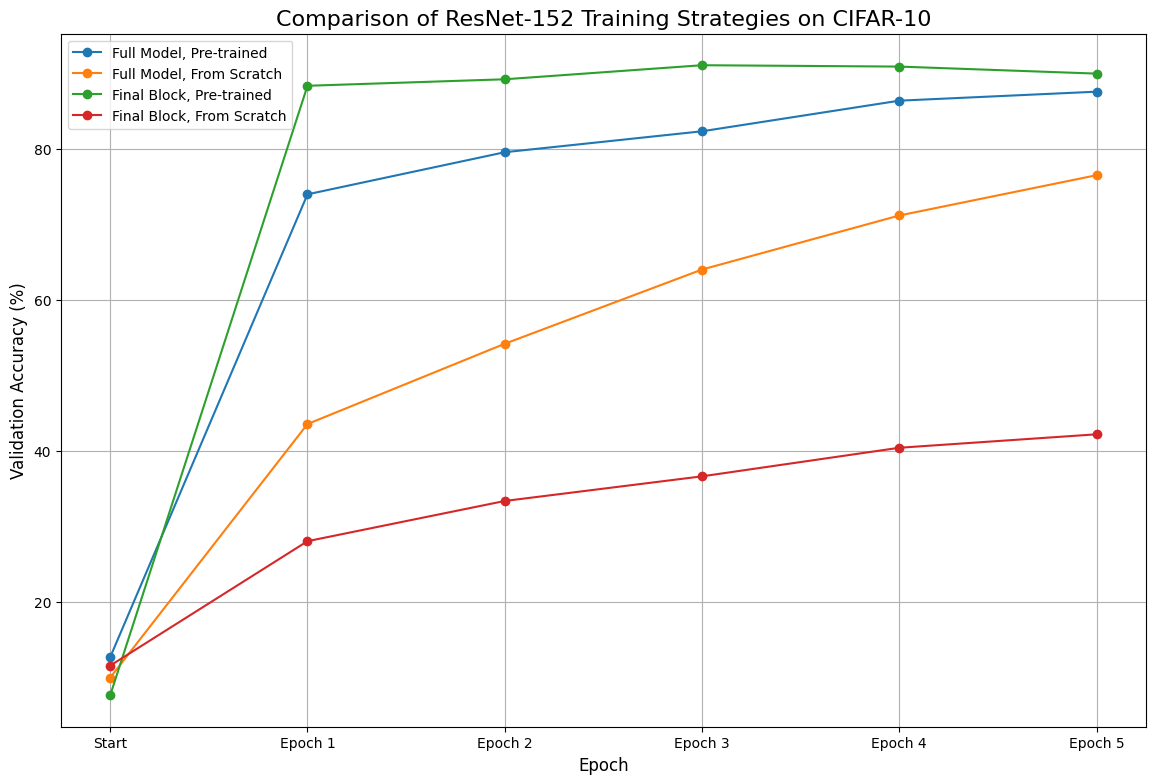

In [12]:
plt.figure(figsize=(14, 9))
plt.plot(history_1, 'o-', label='Full Model, Pre-trained')
plt.plot(history_2, 'o-', label='Full Model, From Scratch')
plt.plot(history_3, 'o-', label='Final Block, Pre-trained')
plt.plot(history_4, 'o-', label='Final Block, From Scratch')

plt.title('Comparison of ResNet-152 Training Strategies on CIFAR-10', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.xticks(np.arange(len(history_1)), labels=[f'Start'] + [f'Epoch {i+1}' for i in range(len(history_1)-1)])
plt.legend()
plt.grid(True)
plt.show()